This Notebook represents my (Jonathan Lampkin) first attempt at a Kaggle non-beginner project, and the Capstone Two Modeling assignment for the Springboard Data Science Career Track Bootcamp.

The Kaggle competition can be found here: https://www.kaggle.com/c/avazu-ctr-prediction/overview.

As stated by the hosts of the competition, the evaluation metric for this project is the Logarithmic Loss (smaller being better).

In [1]:
# General Data Science Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ML Algorithm Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Evaluation Imports
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

# Suppressing XGBoost warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
%%time

# Importing Random Sample (Large Dataset)

num_lines = 40428968
sample_size = 100000
skip = sorted(random.sample(range(1, num_lines), num_lines-sample_size))

df = pd.read_csv('train.gz', header=0, skiprows=skip)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                99999 non-null  uint64
 1   click             99999 non-null  int64 
 2   hour              99999 non-null  int64 
 3   C1                99999 non-null  int64 
 4   banner_pos        99999 non-null  int64 
 5   site_id           99999 non-null  object
 6   site_domain       99999 non-null  object
 7   site_category     99999 non-null  object
 8   app_id            99999 non-null  object
 9   app_domain        99999 non-null  object
 10  app_category      99999 non-null  object
 11  device_id         99999 non-null  object
 12  device_ip         99999 non-null  object
 13  device_model      99999 non-null  object
 14  device_type       99999 non-null  int64 
 15  device_conn_type  99999 non-null  int64 
 16  C14               99999 non-null  int64 
 17  C15         

In [3]:
df.head().T

,0,1,2,3,4
id,10077499053901476068,10081516777024232035,10181607282627715542,10263327996156539760,10489487668654728742
click,0,0,1,0,0
hour,14102100,14102100,14102100,14102100,14102100
C1,1005,1005,1005,1005,1005
banner_pos,0,0,0,0,0
site_id,1fbe01fe,1fbe01fe,1fbe01fe,85f751fd,1fbe01fe
site_domain,f3845767,f3845767,f3845767,c4e18dd6,f3845767
site_category,28905ebd,28905ebd,28905ebd,50e219e0,28905ebd
app_id,ecad2386,ecad2386,ecad2386,851e0632,ecad2386
app_domain,7801e8d9,7801e8d9,7801e8d9,2347f47a,7801e8d9


In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,99999,NaN,NaN,NaN,9.19134e+18,5.33183e+18,4.26543e+13,4.56012e+18,9.17492e+18,1.38093e+19,1.84467e+19
click,99999,NaN,NaN,NaN,0.170672,0.376224,0,0,0,0,1
hour,99999,NaN,NaN,NaN,1.41026e+07,296.846,1.41021e+07,1.41023e+07,1.41026e+07,1.41028e+07,1.4103e+07
C1,99999,NaN,NaN,NaN,1004.97,1.09956,1001,1005,1005,1005,1012
banner_pos,99999,NaN,NaN,NaN,0.289393,0.506723,0,0,0,1,7
site_id,99999,1495,85f751fd,36040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
site_domain,99999,1345,c4e18dd6,37344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
site_category,99999,20,50e219e0,40837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
app_id,99999,1310,ecad2386,63959,NaN,NaN,NaN,NaN,NaN,NaN,NaN
app_domain,99999,101,7801e8d9,67503,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preparing Dataset for ML

In [5]:
%%time

def fix_hour(df):
    df['hour'] = df.hour.astype(str).str[-2:].astype('int')
    
    # ONLY KEEP COLS BELOW
    df['morning'] = df['hour'].map(lambda x: 1 if (x <= 11)& (x >= 7) else 0).astype('int')
    df['day'] = df['hour'].map(lambda x: 1 if (x >= 12) & (x <= 18) else 0).astype('int')
    df['evening'] = df['hour'].map(lambda x: 1 if (x >= 19) & (x <= 23) else 0).astype('int')
    df['night'] = df['hour'].map(lambda x: 1 if (x >= 0) & (x <= 6) else 0).astype('int')
    return df

df = fix_hour(df).drop(['hour'],axis=1)

Wall time: 199 ms


In [6]:
%%time

def binning_text_cols(df):
    
    site_id_map = df['site_id'].isin(['85f751fd','1fbe01fe','e151e245','d9750ee7','5b08c53b','5b4d2eda','856e6d3f','a7853007'])
    site_domain_map = df['site_domain'].isin(['c4e18dd6','f3845767','7e091613','7687a86e','98572c79','16a36ef3','58a89a43'])
    site_category_map = df['site_category'].isin(['50e219e0','f028772b','28905ebd','3e814130'])
    app_domain_map = df['app_domain'].isin(['7801e8d9','2347f47a','ae637522','5c5a694b','82e27996','d9b5648e','0e8616ad','b9528b13','b8d325c3'])
    app_category_map = df['app_category'].isin(['07d7df22','0f2161f8','cef3e649','8ded1f7a','f95efa07','d1327cf5','09481d60','dc97ec06','75d80bbe'])
    app_map = df['app_id'].isin(['ecad2386','92f5800b','e2fcccd2','febd1138','9c13b419','7358e05e','a5184c22','d36838b1'])
    
    df['site_id_fix'] = df['site_id'][site_id_map]
    df['site_domain_fix'] = df['site_domain'][site_domain_map]
    df['site_category_fix'] = df['site_category'][site_category_map]
    df['app_domain_fix'] = df['app_domain'][app_domain_map]
    df['app_category_fix'] = df['app_category'][app_category_map]
    df['app_id_fix'] = df['app_id'][app_map]
    df['device_id_fix'] = np.where(df['device_id'] == 'a99f214a', 1, 0)
    
    df = df.fillna('Unknown')
    return df

df = binning_text_cols(df)

Wall time: 85.8 ms


In [7]:
%%time

# Hypothesis 1: Scaling all columns will be best
def scale_all_cols(df):
    X = df.drop(['id', 'click', 'device_ip', 'device_model', 'site_id','site_domain',
                 'site_category','app_domain','app_category','device_id','app_id'],axis = 1)
    num_cols = X.select_dtypes('number')
    text_cols = X.select_dtypes('object')
    X = pd.concat([num_cols, pd.get_dummies(text_cols)],axis=1)
    X = (X - X.mean()) / X.std()
    y = df['click']
    return X, y

X, y = scale_all_cols(df)

print(X.shape)
print(X.isnull().any().sum())
print(X.dtypes.value_counts())

(99999, 68)
0
float64    68
dtype: int64
Wall time: 125 ms


#### Evaluating imbalance of target variable

In [8]:
y.value_counts(normalize=True,dropna=False)

0    0.829328
1    0.170672
Name: click, dtype: float64

#### Out of Box Model Performance Comparison

In [32]:
# Instantiating Classifiers with default parameters

rf = RandomForestClassifier()
log = LogisticRegression(max_iter=1000)
ada = AdaBoostClassifier()
xgb = XGBClassifier(verbosity=0, use_label_encoder=False)
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
cat = CatBoostClassifier(verbose=0)
lgb = lgb.LGBMClassifier()

models = [cat, lgb, rf, log, ada, xgb, knn, dtc]

AttributeError: 'LGBMClassifier' object has no attribute 'LGBMClassifier'

{'<catboost.core.CatBoostClassifier object at 0x000001D8BD48CEB0>': 0.41490896559136886, 'LGBMClassifier': 0.414225806340074, 'RandomForestClassifier': 0.8588061495103677, 'LogisticRegression': 0.4249823949488022, 'AdaBoostClassifier': 0.6801247364412444, 'XGBClassifier': 0.4160472116896088, 'KNeighborsClassifier': 2.081100796475618, 'DecisionTreeClassifier': 2.9181550382530794}
Wall time: 2min 56s


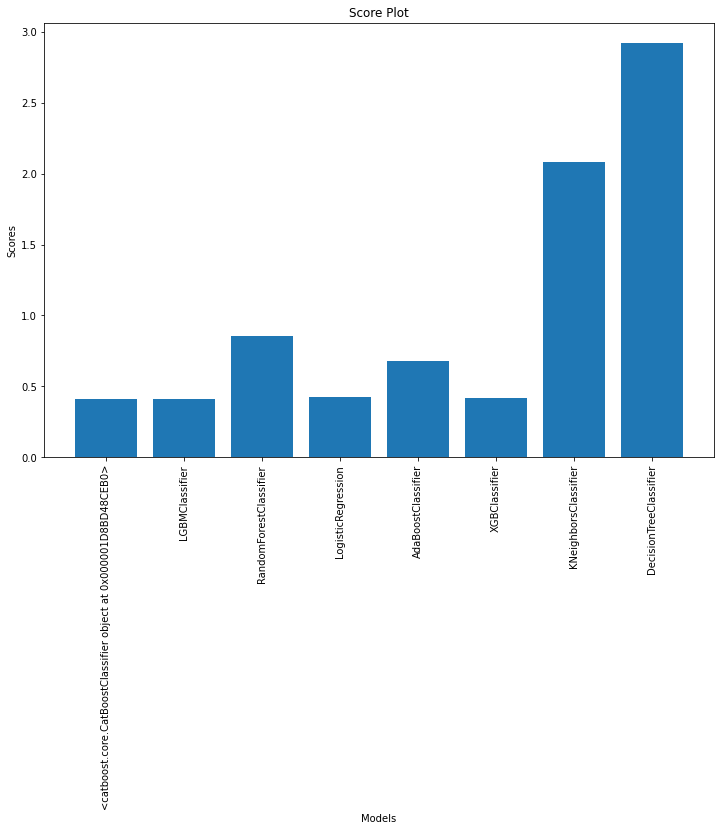

In [10]:
%%time

metric = 'neg_log_loss'

# Function to score an array of machine learning algorithms on the dataset
def strat_k_fold_score_models(X, y, models, metric, folds):
    """
    Description:
    Given a list of model objects and a scoring metric, 
    plots the absolute average score for each model.
    
    Parameters:
    X (n-dimensional matrix): Independent variables / predictor variables
    y (one-dimensional matrix): Target variable / dependent variable
    models (object): List of Instantiated ML algorithm objects.
    metric (string): Single metric in string format to be used in 'cross_val_score' function.
    folds (int): Number of folds to be used in 'cross_val_score' function.
    """
    
    # Random Permutation of Dataset
    p = np.random.permutation(len(X))
    X, y = X.iloc[p], y.iloc[p]
    
    # Empty Dictionary to store model scores.
    model_scores = {}
    
    # Iterates over list of models
    for model in models:
        
        scores = []
        
        kf = StratifiedKFold(n_splits=folds, shuffle=True)
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)
            score = log_loss(y_test, y_pred)
            scores.append(score)
        
        # Saves current iteration's model score to dictionary
        model_scores[str(model).split('(')[0]] = np.mean(scores)
        
    # Arbitrary plot figure size
    plt.figure(figsize=(12,8))
    
    # Plot of model scores (y) vs. model names (x) -- simplifies xtick labels
    #score_plot = plt.bar([x.split('(')[0] for x in model_scores.keys()], model_scores.values())
    score_plot = plt.bar(model_scores.keys(), model_scores.values())
    
    # Labeling Axes
    plt.title('Score Plot')
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.xticks(rotation=90)
    
    # Printing scores
    #print([x.split('(')[0] for x in model_scores.keys()], model_scores.values())
    print(model_scores)
    
    return score_plot

scores2 = strat_k_fold_score_models(X, y, models, metric, 5)

# Optimizing Best Algorithms

In [33]:
# %%time

# xgb_grid = {'learning_rate':[0.03,0.04],
#             'max_depth':[8,8,9], 
#             'min_child_weight':[0.15,0.2], 
#             'subsample':[0.2,0.3,0.4], 
#             'scale_pos_weight':[0.8,0.9,1,1.2],
#             'reg_alpha':[0.4,0.5,0.6]}

# cat_grid = {'max_depth': [6,7,8],
#             'n_estimators':[130,140,150,160,170], 
#             'learning_rate':[0.04,0.05,0.06]}

# lgb_grid ={'num_leaves': [8,9,10,11],
#            'min_child_weight': [0.7,0.8,0.9],
#            'subsample': [0.2,0.3,0.4], 
#            'colsample_bytree': [0.3,0.4,0.5],
#            'reg_alpha': [2,3,4,5],
#            'reg_lambda': [0.03,0.04,0.05,0.06]}

# log_grid ={'C': [0.25,0.5,0.75,1],
#            'class_weight': [None,'balanced'],
#            'solver': ['newton-cg','lbfgs','liblinear','sag','saga']}


# gridsearchxgb = GridSearchCV(estimator=xgb,param_grid=xgb_grid,cv=3,scoring='neg_log_loss')
# gridsearchxgb.fit(X,y)
# xgb_opt = gridsearchxgb.best_estimator_

# gridsearchcat = GridSearchCV(estimator=cat, param_grid=cat_grid,cv=3,scoring='neg_log_loss')
# gridsearchcat.fit(X,y)
# cat_opt = gridsearchcat.best_estimator_

# gridsearchlgb = GridSearchCV(estimator=lgb, param_grid=lgb_grid,cv=3,scoring='neg_log_loss')
# gridsearchlgb.fit(X,y)
# lgb_opt = gridsearchlgb.best_estimator_

# gridsearchlog = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=log_grid,cv=3,scoring='neg_log_loss')
# gridsearchlog.fit(X,y)
# log_opt = gridsearchlog.best_estimator_

# print('xgb params: ', gridsearchxgb.best_params_)
# print('\n', 'cat params: ', gridsearchcat.best_params_)
# print('\n', 'lgb params: ', gridsearchlgb.best_params_)
# print('\n', 'log params: ', gridsearchlog.best_params_)


 log params:  {'C': 0.25, 'class_weight': None, 'solver': 'liblinear'}


xgb params:  {'subsample': 0.4, 'scale_pos_weight': 0.8, 'reg_alpha': 0.5, 'min_child_weight': 0.3, 'max_depth': 6, 'learning_rate': 0.04}

 cat params:  {'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.04}

 lgb params:  {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 3, 'num_leaves': 15, 'min_child_weight': 0.75, 'colsample_bytree': 0.5}
 
 xgb params:  {'subsample': 0.8, 'scale_pos_weight': 0.9, 'reg_alpha': 0.3, 'min_child_weight': 0.2, 'max_depth': 5, 'learning_rate': 0.09}

 cat params:  {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.03}

 lgb params:  {'subsample': 0.3, 'reg_lambda': 0.05, 'reg_alpha': 1, 'num_leaves': 10, 'min_child_weight': 0.9, 'colsample_bytree': 0.6}
 
 xgb params:  {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 0.15, 'reg_alpha': 0.5, 'scale_pos_weight': 1, 'subsample': 0.3}

 cat params:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 170}

 lgb params:  {'colsample_bytree': 0.4, 'min_child_weight': 0.8, 'num_leaves': 10, 'reg_alpha': 3, 'reg_lambda': 0.05, 'subsample': 0.3}

 log params:  {'C': 0.25, 'class_weight': None, 'solver': 'newton-cg'}
Wall time: 2h 17min 16s

xgb params:  {'learning_rate': 0.04, 'max_depth': 8, 'min_child_weight': 0.2, 'reg_alpha': 0.5, 'scale_pos_weight': 1, 'subsample': 0.4}

 cat params:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 170}

 lgb params:  {'colsample_bytree': 0.4, 'min_child_weight': 0.7, 'num_leaves': 10, 'reg_alpha': 5, 'reg_lambda': 0.04, 'subsample': 0.2}

 log params:  {'C': 0.25, 'class_weight': None, 'solver': 'liblinear'}
  log params:  {'C': 0.25, 'class_weight': None, 'solver': 'liblinear'}
Wall time: 1h 46min 58s

#### Comparing Optimized Algorithms with Stack of Best Algorithms

In [35]:
%%time

opt_models = [('xgb_opt',xgb_opt), ('cat_opt', cat_opt), ('lgb_opt', lgb_opt), ('log_opt', log_opt)]

kf = StratifiedKFold(n_splits=5, shuffle=True)


for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for name, estimator in opt_models:
        stack = StackingClassifier(estimators=opt_models, final_estimator=estimator)
        stack.fit(X_train, y_train)
        score = log_loss(y_test, stack.predict_proba(X_test))
        print(name, score)
    

xgb_opt 0.4171875803200528
cat_opt 0.41534357903259594
lgb_opt 0.4159970585845269
log_opt 0.4194028546623027
xgb_opt 0.41819209789661693
cat_opt 0.41695749337159116
lgb_opt 0.41747813208919105
log_opt 0.42174581742274075
xgb_opt 0.41754095799792557
cat_opt 0.41627077184543415
lgb_opt 0.41690541470306625
log_opt 0.4209707357045656
xgb_opt 0.41822742109550165
cat_opt 0.4167715535884416
lgb_opt 0.41700458421962777
log_opt 0.4214507050443271
xgb_opt 0.4151453215264138
cat_opt 0.4143872656348495
lgb_opt 0.41459570456230505
log_opt 0.4180277208242068
Wall time: 11min 54s


{'XGBClassifier': 0.4159271138112917, '<catboost.core.CatBoostClassifier object at 0x000001D95834B190>': 0.4169411612879637, 'LGBMClassifier': 0.41678763937114144, 'StackingClassifier': 0.414406603298218}
Wall time: 3min 15s


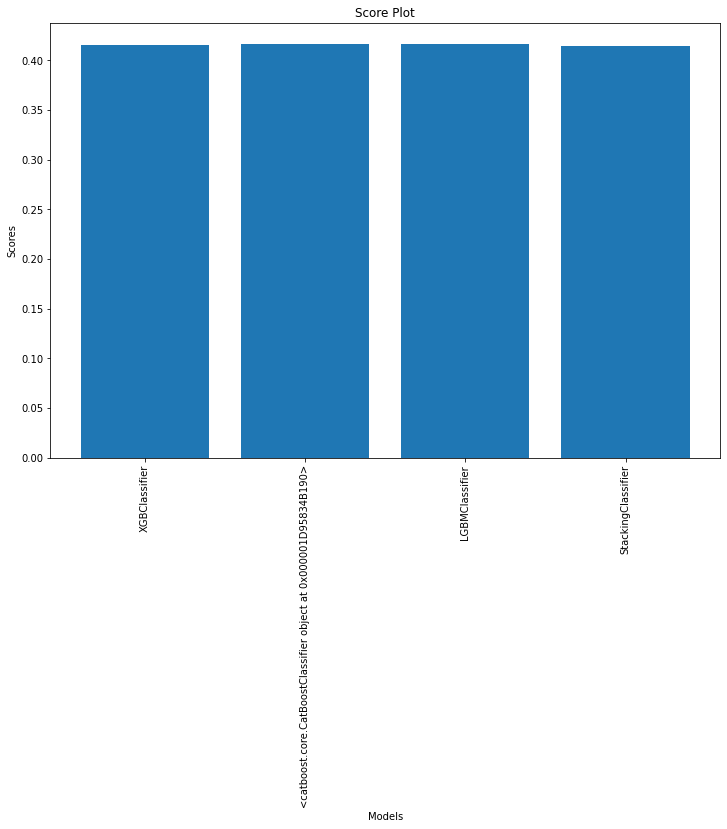

In [36]:
%%time

stack_opt = StackingClassifier(estimators=opt_models, final_estimator = cat_opt)
best_models = [xgb_opt, cat_opt, lgb_opt, stack_opt]

opt_scores = strat_k_fold_score_models(X, y, best_models, metric, 5)

### I will use the StackingClassifier, consisting of a XGBoostClassifer, CatBoostClassifier, and LGBMClassifier because ensemble methods are proven incredibly powerful models.